# Objective of the project 🚀

My objective is to create a machine learning model for object classification and then, try and compare it with a convolutional neural network (CNN) for images. For that, I will use Spark MLlib to train and evaluate the model. Secondly, create the CNN and compare both 🪐




# First Steps

## Download the data

The source of the data is: https://skyserver.sdss.org/CasJobs/
It is necessary to register and login a user to download the data you want. Then, you have to make a query specifying:
- Amount of rows
- Columns
- Where to keep the csv
- The database

As I want to get as much as possible data, I will not a maximum of rows.

I also add a "where" so I can get only data from planets, galaxies and stars:
- type = 3: Galaxies
- type = 6: Stars

and I downloaded the dataset to start working with it.

<img src="/home/haizeagonzalez/myproject/bigDataAstronomy/notebookImages/img1.png">

## Understanding the data

The columns we have are:
- objID: Unique identifier of the object → TYPE bigInt
- ra: Right ascension → TYPE float
- dec: Declination → TYPE float
- petroRad: Petrosian radius, used to know the size of galaxies in astronomical pictures. It is the amount of light that a galaxy emits in a sepecific radius. Very used because it is independent of the distance and brightness. We use different photometric filters:
    - petroRad_u: Near-ultraviolet
    - petroRad_g: Blue-Green
    - petroRad_r: Red
    - petroRad_i: Near-infrared
    - petroRad_z: Deeper infrared
 → TYPE: Real

- modelMag: Brightness measure adjusted to a galaxy model. Usual for galaxies. Also for all filters (u, g, r, i and z) → TYPE Real
- psfMag: Brightness measure based on the point source light profile. Usual for stars. Also for all filters (u, g, r, i and z) → TYPE Real
- u_g: (modelMag_u - modelMag_g)
- g_r: (modelMag_g - modelMag_r)
- r_i: (modelMag_r - modelMag_i)
- i_z: (modelMag_i - modelMag_z)
- fracDeV: The amount of brightness that the object has in the De Vaucouleurs profile. Also for all filters (u, g, r, i and z) → TYPE Real
- flags: Bit comination that explains different characteristics of the object. If we convert it to binary and check SDSS documentarion, we get a meaning for each bit → TYPE bigInt
- clean: Indicator that tell us if the object was cleaned → TYPE int



### What for?

PetroRad:
- Stars: Small and constant in all filters.
- Galaxies: Bigger and variates depending on the wavelengths.

ModelMag and psfMag:
- In the red filter:
    - Stars: modelMag_r ≈ psfMag_r
    - Galaxies: modelMag_r > psfMag_r
- In other filers:
    - Galaxies are usuarlly more red  (modelMag_g - modelMag_r is big).
    - Stars has different colors depending on their type.

fracDeV:
- Stars: fracDeV ≈ 0.
- Galaxies: fracDeV ≈ 1 (eliptic) or fracDeV < 1 (espiral).



# Spark

## Spark configuration

First, we need to create a spark sesion in case there is no one or get if there exists: "getOrCreate". I also decided to create a log in case there is any error during the process.

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("bigDataAstronomyProject") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.instances", "1") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

your 131072x1 screen size is bogus. expect trouble
25/03/28 10:59:38 WARN Utils: Your hostname, SSMRS3-04899600 resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/03/28 10:59:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/28 10:59:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Then, we need to read de csv data.

In [ ]:
import config

df = spark.read.csv(config.DATA_PATH, header=True)
print(df.count())
#df2 = spark.read.csv(config.DATA_PATH2, header=True)
#print(df2.count())

#df = df.union(df2)
#print(df.count())

Now, we are going to check if the data is correctly loaded.

In [ ]:
df.show()

The schema and the chacacteristics of the data.

In [ ]:
df.printSchema()

As all columns are string, we need to convert them into their type. For that:

In [ ]:
from pyspark.sql.functions import col

df = df.withColumn("objID", col("objID").cast("long")) \
       .withColumn("ra", col("ra").cast("float")) \
       .withColumn("dec", col("dec").cast("float")) \
       .withColumn("petroRad_u", col("petroRad_u").cast("float")) \
       .withColumn("petroRad_g", col("petroRad_g").cast("float")) \
       .withColumn("petroRad_r", col("petroRad_r").cast("float")) \
       .withColumn("petroRad_i", col("petroRad_i").cast("float")) \
       .withColumn("petroRad_z", col("petroRad_z").cast("float")) \
       .withColumn("modelMag_u", col("modelMag_u").cast("float")) \
       .withColumn("modelMag_g", col("modelMag_g").cast("float")) \
       .withColumn("modelMag_r", col("modelMag_r").cast("float")) \
       .withColumn("modelMag_i", col("modelMag_i").cast("float")) \
       .withColumn("modelMag_z", col("modelMag_z").cast("float")) \
       .withColumn("psfMag_u", col("psfMag_u").cast("float")) \
       .withColumn("psfMag_g", col("psfMag_g").cast("float")) \
       .withColumn("psfMag_r", col("psfMag_r").cast("float")) \
       .withColumn("psfMag_i", col("psfMag_i").cast("float")) \
       .withColumn("psfMag_z", col("psfMag_z").cast("float")) \
       .withColumn("u_g", col("u_g").cast("float")) \
       .withColumn("g_r", col("g_r").cast("float")) \
       .withColumn("r_i", col("r_i").cast("float")) \
       .withColumn("i_z", col("i_z").cast("float")) \
       .withColumn("fracDeV_u", col("fracDeV_u").cast("float")) \
       .withColumn("fracDeV_g", col("fracDeV_g").cast("float")) \
       .withColumn("fracDeV_r", col("fracDeV_r").cast("float")) \
       .withColumn("fracDeV_i", col("fracDeV_i").cast("float")) \
       .withColumn("fracDeV_z", col("fracDeV_z").cast("float")) \
       .withColumn("flags", col("flags").cast("long")) \
       .withColumn("clean", col("clean").cast("int"))

df.printSchema()

Now that we have all the structure, we are going to explore and clean the data.

## Data cleaning and understanding

In principle, the data is cleaned because we get it from CasJobs and we apply clear filter to get good data. 
However, we are going to check whether there is any null value and the amount of galaxies and stars.  

In [ ]:
from pyspark.sql.functions import col, when, count

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

number_stars = df.filter(df.type == 6).count()
number_galaxies = df.filter(df.type == 3).count()

#Convert the data into a dataframe to make the plot
data = pd.DataFrame({
    "type": ["Stars", "Galaxies"],
    "count": [number_stars, number_galaxies]
})


plt.figure(figsize=(8, 6))
plt.bar(data["type"], data["count"], color=["#ff9300", "#42c9c9"])
plt.xlabel("Object type")
plt.ylabel("Count")
plt.title("Total of Stars and Galaxies")


plt.show()

As we can see, there is no null values and the amount of galaxies are less than the amount of stars, which make sense.

The next step is to change "type" label. As it is a binary classification, we will update stars to 0 and galaxies to 1.

In [ ]:
df = df.withColumn("type", when(col("type") == 3,1).otherwise(0))

In [ ]:
df_stars = df.filter(df["type"] == 0)
df_galaxies = df.filter(df["type"] == 1)

#Print to know the conversion is correctly done
df_stars.show(5)
df_galaxies.show(5)

As for the supervised machine model we won't use objID, ra, dec, flags and clean columns, we are going to remove them. 

In [ ]:
df_ml_model = df.select("type", "petroRad_u", "petroRad_g", "petroRad_r", "petroRad_i", "petroRad_z",
                        "modelMag_u", "modelMag_g", "modelMag_r", "modelMag_i", "modelMag_z",
                        "psfMag_u", "psfMag_g", "psfMag_r", "psfMag_i", "psfMag_z",
                        "u_g", "g_r", "r_i", "i_z",
                        "fracDeV_u", "fracDeV_g", "fracDeV_r", "fracDeV_i", "fracDeV_z")

df_ml_model.printSchema()

## Spark ML

As our objective is to create a machine learning model, we need to convert the data in a correct format: Vectors.

In [ ]:
from pyspark.ml.feature import VectorAssembler

features = df_ml_model.columns[1:] #We don't get the type beacuse is the result we want to get.
assembler = VectorAssembler(inputCols = features, outputCol = "features") #Convert features list as a vector
df_ml_model = assembler.transform(df_ml_model) #Apply transformation
df_ml_model = df_ml_model.select("features", "type")

df_ml_model.head(5)

Now, we are going to divide the dataset into train and test, so we can get the accuracy of the model.

In [ ]:
train_data, test_data = df_ml_model.randomSplit([0.8, 0.2], seed = 132)

We are going to try different models to check which is the best for our case.

In [ ]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LinearSVC

#Define different models
models = {
    "Logistic Regression": LogisticRegression(labelCol="type", featuresCol="features"),
    "Decision Tree": DecisionTreeClassifier(labelCol="type", featuresCol="features"),
    "Random Forest": RandomForestClassifier(labelCol="type", featuresCol="features", numTrees=5),
    "Gradient Boosted Trees": GBTClassifier(labelCol="type", featuresCol="features"),
    "Linear SVM": LinearSVC(labelCol="type", featuresCol="features")
}

Now, we are going to calculate the **AUC evaluator** for model and look how well they are doing. I decided to use AUC because it is a good technique to use for binary classification, especially when classes are unbalanced.

Remember that the ROC curve gives a visual representation between the true prositive rate and false positive rate at different thresholds. So, it tell us how well the model can detect true positive and avoid false positives. Moreover, AUC is one scalar value from 0 to  that tell how the model performs globally. AUC represents the area beneath the curve.
- AUC = 0.5 ⭢ Random Predictions
- AUC > 0.5 ⭢ Increasingly good predictions
- AUC = 1 ⭢ Perfect predictions



<img src="/home/haizeagonzalez/myproject/bigDataAstronomy/notebookImages/img2.png">

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import auc

evaluator = BinaryClassificationEvaluator(labelCol="type", metricName="areaUnderROC")

for name, model in models.items():
    model_trained = model.fit(train_data)
    predictions = model_trained.transform(test_data)
    auc = evaluator.evaluate(predictions)
    print(f"{name}: AUC = {auc:.4f}")

In [ ]:
from sklearn.metrics import roc_curve, auc

#Create the figure
plt.figure(figsize=(10, 8))

#Different colors for the different models
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

#For each model compute the AUC
for idx, (name, model) in enumerate(models.items()):
    model_trained = model.fit(train_data)
    predictions = model_trained.transform(test_data) #Predicted class (0 or 1)

    #Check if the model has "probability" column because some of them (SVG for example) do not
    if "probability" in predictions.columns:
        #Get the whole probability vector, convert it into rdd and select the probability for the positive (real) prediction
        prob_positives = predictions.select("probability").rdd.map(lambda row: row[0][1]).collect()
        #Get the label for each prediction
        true_labels = predictions.select("type").rdd.map(lambda row: row[0]).collect()

        #Calculate ROC curve
        fpr, tpr, _ = roc_curve(true_labels, prob_positives)
        roc_auc = auc(fpr, tpr)

        #Plot it
        plt.plot(fpr, tpr, color=colors[idx % len(colors)], lw=2, label=f'{name} (AUC = {roc_auc:.4f})')
    else:
        print(f"The model {name} does not have 'probability' column so it will not be in the graphic.")

#Different parameters to personalize the plot
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  #Diagonal line of "random"
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()

plt.show()

As we can see, the best AUC is the one for logistic regression so we will use that model in order to make our predictions. 

Then, as our model has a very high AUC, we need to ensure that it is not overfitted. A high AUC does not necessarily mean good generalization; it could indicate that the model memorized the training data.

To ensure about this, we will compute the confusion matrix for training and test sets. Comparing both we will know if the model is performing well or not with unseen data. We will use plots to visualize the matrices in order to make an easier and more interpetable comparison.

In [ ]:
lr = LogisticRegression(labelCol="type", featuresCol="features")
lr_model = lr.fit(train_data)

predictions_log_train = lr_model.transform(train_data)
predictions_log_test = lr_model.transform(test_data)

auc_train = evaluator.evaluate(predictions_log_train)
auc_test = evaluator.evaluate(predictions_log_test)

print(f"Logistic Regression (Train): AUC = {auc_train:.4f}\n")
print(f"Logistic Regression (Test): AUC = {auc_test:.4f}")

As we can see, the difference is almost non-existent which is good because this suggests that the model is generalizing correctly, data for train and test set are representative of the data. However, as it is a very high AUC, we can verify the confusion matrix in order to know if the model is correctly classifying. To make this, we will use the plot of the confusion matrix to visualize to get a conclusion in a easier and more interpetable way.

In [ ]:
from pyspark.sql import functions as F
import seaborn as sns
import numpy as np

#Divide true positives, true negatives, false positives and false negatives
##Train
true_galaxies_train = predictions_log_train.filter((F.col("type") == 1) & (F.col("prediction") == 1)).count()
true_stars_train = predictions_log_train.filter((F.col("type") == 0) & (F.col("prediction") == 0)).count()
false_stars_train = predictions_log_train.filter((F.col("type") == 0) & (F.col("prediction") == 1)).count()
false_galaxies_train = predictions_log_train.filter((F.col("type") == 1) & (F.col("prediction") == 0)).count()

#Creating the confusion matrix
conf_matrix_values_train = [[true_stars_train, false_stars_train], [false_galaxies_train, true_galaxies_train]]


##Test
true_galaxies_test = predictions_log_test.filter((F.col("type") == 1) & (F.col("prediction") == 1)).count()
true_stars_test = predictions_log_test.filter((F.col("type") == 0) & (F.col("prediction") == 0)).count()
false_stars_test = predictions_log_test.filter((F.col("type") == 0) & (F.col("prediction") == 1)).count()
false_galaxies_test = predictions_log_test.filter((F.col("type") == 1) & (F.col("prediction") == 0)).count()

#Creating the confusion matrix
conf_matrix_values_test = [[true_stars_test, false_stars_test], [false_galaxies_test, true_galaxies_test]]


#Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  #Create two plots in 1 line

#Train confusion matrix
ax1 = sns.heatmap(np.array(conf_matrix_values_train), annot=True, fmt="d", cmap="Blues",
                   xticklabels=["Stars prediction", "Galaxies prediction"],
                   yticklabels=["Real stars", "Real galaxies"], ax=axes[0]) #Put in the axe 0, the left one
ax1.set_xlabel("Prediction")
ax1.set_ylabel("Real value")
ax1.set_title("Confusion Matrix - Train")

#Test confusion matrix
ax2 = sns.heatmap(np.array(conf_matrix_values_test), annot=True, fmt="d", cmap="Blues",
                   xticklabels=["Stars prediction", "Galaxies prediction"],
                   yticklabels=["Real stars", "Real galaxies"], ax=axes[1]) #Put in the axe 0, the right one
ax2.set_xlabel("Prediction")
ax2.set_ylabel("Real value")
ax2.set_title("Confusion Matrix - Test")


plt.tight_layout()
plt.show()


To detect if there is or not overfitting, we need to compare the error rate in train and test set. 

In [ ]:
##Train
false_stars_train = conf_matrix_values_train[1][0]
true_galaxies_train = conf_matrix_values_train[1][1]

false_stars_train_rate = ((false_stars_train)/(false_stars_train + true_galaxies_train))*100
false_stars_train_rate = round(false_stars_train_rate,2)


##Test
false_stars_test = conf_matrix_values_test[1][0]
true_galaxies_test = conf_matrix_values_test[1][1]

false_stars_test_rate = ((false_stars_test)/(false_stars_test + true_galaxies_test))*100
false_stars_test_rate = round(false_stars_test_rate,2)


#PLOTS
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  #Create two plots in 1 line

labels_train = ["Correct Predictions", "False Stars"]
sizes_train = [100 - false_stars_train_rate, false_stars_train_rate]
colors_train = ["#ff9300", "#9b9c9c"]
axes[0].pie(sizes_train, labels=labels_train, colors=colors_train, autopct='%1.1f%%', startangle=140)
axes[0].set_title(f"Train - False Stars Rate: {false_stars_train_rate}%")

# Pie Chart para Test
labels_test = ["Correct Predictions", "False Stars"]
sizes_test = [100 - false_stars_test_rate, false_stars_test_rate]
colors_test = ["#ff9300", "#9b9c9c"]
axes[1].pie(sizes_test, labels=labels_test, colors=colors_test, autopct='%1.1f%%', startangle=140)
axes[1].set_title(f"Test - False Stars Rate: {false_stars_test_rate}%")

plt.tight_layout()
plt.show()


In [ ]:
##Train
false_galaxies_train = conf_matrix_values_train[0][1]
true_stars_train = conf_matrix_values_train[0][0]

false_galaxies_train_rate = ((false_galaxies_train)/(false_galaxies_train + true_stars_train))*100
false_galaxies_train_rate = round(false_galaxies_train_rate,2)

##Test
false_galaxies_test = conf_matrix_values_test[0][1]
true_stars_test = conf_matrix_values_test[0][0]

false_galaxies_test_rate = ((false_galaxies_test)/(false_galaxies_test + true_stars_test))*100
false_galaxies_test_rate = round(false_galaxies_test_rate,2)


#PLOTS
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  #Create two plots in 1 line

labels_train = ["Correct Predictions", "False Stars"]
sizes_train = [100 - false_galaxies_train_rate, false_galaxies_train_rate]
colors_train = ["#42c9c9", "#9b9c9c"]
axes[0].pie(sizes_train, labels=labels_train, colors=colors_train, autopct='%1.1f%%', startangle=140)
axes[0].set_title(f"Train - False Galaxies Rate: {false_galaxies_train_rate}%")

# Pie Chart para Test
labels_test = ["Correct Predictions", "False Stars"]
sizes_test = [100 - false_galaxies_test_rate, false_galaxies_test_rate]
colors_test = ["#42c9c9", "#9b9c9c"]
axes[1].pie(sizes_test, labels=labels_test, colors=colors_test, autopct='%1.1f%%', startangle=140)
axes[1].set_title(f"Test - False Galaxies Rate: {false_galaxies_test_rate}%")

plt.tight_layout()
plt.show()


As both rates (train and test) are very similar, the model is not overfitting so it is generalizing correctly the data. However, As the AUC value is very big, we can use **regularization** technique to make a more robust model. Regularization is intended to prevent overfitting by penalizing large coefficients and forcing the model to learn simpler, more generalizable patterns. There are different types of regularization (L1, L2 (same that L1 but squared), L1+L2, dropout,...). In this case, we will use L2 regularization because it is the most estable one and because all the selected variables are relevant. For that, it is necessary to add *regParam* to the Logistic Regression. The selected value 0.1 is because it is a simple model, it has not many variables (just 24).

In [ ]:
lr_with_reg = LogisticRegression(labelCol="type", featuresCol="features", regParam=0.1)
model_with_reg = lr_with_reg.fit(train_data)

#Evaluate the model with regularization
predictions_with_reg = model_with_reg.transform(test_data)
auc_with_reg = evaluator.evaluate(predictions_with_reg)
print(f"Logistic Regression (Regularization): AUC = {auc_with_reg:.4f}")

As we can see, the AUC has decreased from 0.9919 to 0.9066 (in test). This will be good for the model to learn more generalizable patterns and not to overfit.

# Images

As I need also de images, I have downloaded from https://skyserver.sdss.org/dr18, specifying with a request:
- the location of the object (with right ascension (RA) and declination (dec))
- the zoom of the picture (scale)
- the dimmensions of the photo (with and height)

These images will be saved into a "images" folder splitted into train and test and each one splitted as galaxies or stars. In a visual way would be:
|
|
images
   |
   |_ train
       |
       |_ star
       |_ galaxy
    |
    |_ test
       |
       |_ star
       |_ galaxy
   
This python file is out of this notebook not to collapse spark, its name is "download_images.py".
   

## Data preprocessing

First it is necessary to know the amount of channels we are going to work with. For that, we are going to take one photo and verify it.

In [2]:
import cv2
import os
import config

image_path = config.IMAGES_PATH + "/train/star"

#Get all the images
images = [f for f in os.listdir(image_path) if f.endswith((".jpg"))]

image_path = os.path.join(image_path, images[0]) #Get the first photo

image = cv2.imread(image_path) #Read the first photo

if len(image.shape) == 2:
    print("Image with grayscale.")
elif len(image.shape) == 3 and image.shape[2] == 3:
    print("Image with 3 channels (RGB).")
elif len(image.shape) == 3 and image.shape[2] == 4:
    print("Image with 4 channels (RGBA).") #RGB + Alpha (opacity of the image)

Image with 3 channels (RGB).


As we can see our images have 3 channels RGB. Now, we are going to normalize the pixels values  because we are going to work with a neural network and usually this improves the model performance and facilitate the process of learning. 

In [4]:
import torch
import numpy as np
from torchvision import datasets
from torchvision import datasets, transforms

# Suponiendo que tus imágenes están en un dataset cargado por DataLoader
dataset = datasets.ImageFolder(config.IMAGES_PATH, transform=transforms.ToTensor())
# Inicializar contadores para los valores acumulados
mean = 0.0
std = 0.0
total_images = len(dataset)

for img, _ in dataset:
    mean += torch.mean(img, dim=[1, 2])  # Promedio de cada canal
    std += torch.std(img, dim=[1, 2])  # Desviación estándar de cada canal

mean2 = mean / total_images
std2 = std / total_images

print('Mean:', mean2)
print('STD:', std2)

Mean: tensor([0.0645, 0.0423, 0.0293])
STD: tensor([0.0810, 0.0660, 0.0439])


In [6]:
import torch, config
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),          # Convertir las imágenes a tensores
    transforms.Normalize(mean=[0.0645, 0.0423, 0.0293], std=[0.0810, 0.0660, 0.0439]) 
    #media y la desviación estándar de los píxeles en cada uno de los tres canales de color
    #(rojo, verde y azul) de las imágenes.
])

# Cargar los conjuntos de entrenamiento y prueba
train_dataset = datasets.ImageFolder(root=config.IMAGES_PATH+"/train", transform=transform)
test_dataset = datasets.ImageFolder(root=config.IMAGES_PATH+"/test", transform=transform)

# Crear los DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
#En el conjunto de prueba, no es necesario mezclar las imágenes porque la evaluación no debe
# depender del orden. Así que deberías cambiarlo a shuffle=False para el test_loader


In [42]:
from collections import Counter

# Función para contar las clases en un DataLoader
def count_classes(data_loader):
    class_counts = Counter()
    for _, labels in data_loader:
        class_counts.update(labels.numpy())  # Actualizar el contador de clases
    return class_counts

# Contar las clases en el conjunto de entrenamiento
train_class_counts = count_classes(train_loader)
print("Conteo de clases en el conjunto de entrenamiento:")
for class_idx, count in train_class_counts.items():
    class_name = train_dataset.classes[class_idx]
    print(f"{class_name}: {count}")

# Contar las clases en el conjunto de prueba
test_class_counts = count_classes(test_loader)
print("Conteo de clases en el conjunto de prueba:")
for class_idx, count in test_class_counts.items():
    class_name = test_dataset.classes[class_idx]
    print(f"{class_name}: {count}")


Conteo de clases en el conjunto de entrenamiento:
star: 37785
galaxy: 14932
Conteo de clases en el conjunto de prueba:
galaxy: 3733
star: 9446


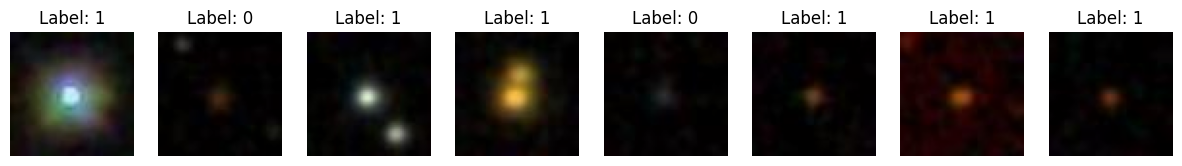

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener las primeras 5 imágenes y sus etiquetas del DataLoader
def show_images(data_loader, num_images=5):
    # Iterar sobre el DataLoader
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # Mostrar las imágenes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    
    # Valores de la media y desviación estándar para deshacer la normalización
    mean = np.array([0.0645, 0.0423, 0.0293])
    std = np.array([0.0810, 0.0660, 0.0439])
    
    for i in range(num_images):
        # Convertir el tensor de la imagen a un formato adecuado para mostrar
        image = images[i].permute(1, 2, 0).numpy()  # Cambiar el orden de las dimensiones para que sea (H, W, C)
        
        # Deshacer la normalización
        image = image * std + mean  # Multiplicar por std y sumar mean
        
        # Clipping para asegurar que los valores estén entre 0 y 1
        image = np.clip(image, 0, 1)

        ax = axes[i]
        ax.imshow(image)
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')

    plt.show()

# Mostrar las primeras 5 imágenes del conjunto de entrenamiento
show_images(train_loader, num_images=8)


### Model

#### Preparation

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Bloque Squeeze-and-Excitation (SE)
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.fc1 = nn.Linear(channel, channel // reduction, bias=False)
        self.fc2 = nn.Linear(channel // reduction, channel, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1)
        y = y.view(b, c)
        y = self.fc1(y)
        y = F.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)
        return x * y

# Red convolucional con bloques SE
class CNNWithSE(nn.Module):
    def __init__(self, num_classes=2):  # 2 clases: estrellas y galaxias
        super(CNNWithSE, self).__init__()
        
        # Capas convolucionales
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        # Bloques SE
        self.se1 = SELayer(64)
        self.se2 = SELayer(128)
        self.se3 = SELayer(256)

        # Capa totalmente conectada
        self.fc = nn.Linear(256 * 8 * 8, num_classes)  # Después de 3 capas convolucionales y maxpooling

    def forward(self, x):
        # Pasar por las capas convolucionales
        x = F.relu(self.conv1(x))
        x = self.se1(x)  # Aplicar SE después de la primera capa
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv2(x))
        x = self.se2(x)  # Aplicar SE después de la segunda capa
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv3(x))
        x = self.se3(x)  # Aplicar SE después de la tercera capa
        x = F.max_pool2d(x, 2)

        # Aplanar las características y pasar a la capa FC
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Crear el modelo
model = CNNWithSE(num_classes=2)  # 2 clases: estrellas y galaxias

# Ver el modelo
print(model)


CNNWithSE(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (se1): SELayer(
    (fc1): Linear(in_features=64, out_features=4, bias=False)
    (fc2): Linear(in_features=4, out_features=64, bias=False)
    (sigmoid): Sigmoid()
  )
  (se2): SELayer(
    (fc1): Linear(in_features=128, out_features=8, bias=False)
    (fc2): Linear(in_features=8, out_features=128, bias=False)
    (sigmoid): Sigmoid()
  )
  (se3): SELayer(
    (fc1): Linear(in_features=256, out_features=16, bias=False)
    (fc2): Linear(in_features=16, out_features=256, bias=False)
    (sigmoid): Sigmoid()
  )
  (fc): Linear(in_features=16384, out_features=2, bias=True)
)


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNWithSE()  # 2 clases: por ejemplo, "estrella" y "galaxia"
model.to(device)

CNNWithSE(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (se1): SELayer(
    (fc1): Linear(in_features=64, out_features=4, bias=False)
    (fc2): Linear(in_features=4, out_features=64, bias=False)
    (sigmoid): Sigmoid()
  )
  (se2): SELayer(
    (fc1): Linear(in_features=128, out_features=8, bias=False)
    (fc2): Linear(in_features=8, out_features=128, bias=False)
    (sigmoid): Sigmoid()
  )
  (se3): SELayer(
    (fc1): Linear(in_features=256, out_features=16, bias=False)
    (fc2): Linear(in_features=16, out_features=256, bias=False)
    (sigmoid): Sigmoid()
  )
  (fc): Linear(in_features=16384, out_features=2, bias=True)
)

In [10]:
import torch.optim as optim

# Definir el optimizador
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir la función de pérdida (CrossEntropyLoss para clasificación)
criterion = nn.CrossEntropyLoss()

In [13]:
# Número de épocas para entrenar
epochs = 10

# Ciclo de entrenamiento
for epoch in range(epochs):
    model.train()  # Configurar el modelo en modo de entrenamiento
    running_train_loss = 0.0

    # Entrenamiento
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Mover datos a la GPU si está disponible

        # Poner a cero los gradientes de los optimizadores
        optimizer.zero_grad()

        # Pasar las imágenes por el modelo
        outputs = model(images)

        # Calcular la pérdida
        loss = criterion(outputs, labels)

        # Retropropagar el error
        loss.backward()

        # Actualizar los pesos del modelo
        optimizer.step()

        running_train_loss += loss.item()

    # Evaluación en el conjunto de test
    model.eval()  # Configurar el modelo en modo de evaluación
    running_test_loss = 0.0
    with torch.no_grad():  # Desactivar los gradientes para la evaluación
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Pasar las imágenes por el modelo
            outputs = model(images)

            # Calcular la pérdida
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

    # Imprimir la pérdida media de entrenamiento y test
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {running_train_loss/len(train_loader):.4f}, Test Loss: {running_test_loss/len(test_loader):.4f}")


Epoch [1/10], Train Loss: 0.0911, Test Loss: 0.2539
Epoch [2/10], Train Loss: 0.0780, Test Loss: 0.3032
Epoch [3/10], Train Loss: 0.0629, Test Loss: 0.3225
Epoch [4/10], Train Loss: 0.0527, Test Loss: 0.3307
Epoch [5/10], Train Loss: 0.0480, Test Loss: 0.3723
Epoch [6/10], Train Loss: 0.0383, Test Loss: 0.4600
Epoch [7/10], Train Loss: 0.0328, Test Loss: 0.5134
Epoch [8/10], Train Loss: 0.0348, Test Loss: 0.3832
Epoch [9/10], Train Loss: 0.0271, Test Loss: 0.4844
Epoch [10/10], Train Loss: 0.0277, Test Loss: 0.5712


In [14]:
model.eval()  # Configurar el modelo en modo de evaluación
correct = 0
total = 0

with torch.no_grad():  # No necesitamos calcular los gradientes durante la evaluación
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Hacer predicciones
        outputs = model(images)

        # Obtener la clase predicha (la que tiene la mayor probabilidad)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

Accuracy of the model on the test images: 91.52%
